# Image Pyramids & Blending in OpenCV

**Goal**: Learn about Gaussian/Laplacian pyramids, `cv.pyrUp`, `cv.pyrDown`, and how to blend images seamlessly (e.g. Orange + Apple = Orapple).

## 목차
1. **이론**: 이미지 피라미드(가우시안, 라플라시안), 블렌딩 개념
2. **Colab 준비**: 라이브러리 설치 & 이미지 준비
3. **Gaussian Pyramid** 실습 (`cv.pyrDown`, `cv.pyrUp`)
4. **Laplacian Pyramid** 실습
5. **Blending (오렌지+사과)**
6. **과제**
7. **Q&A**


# 1. 이론: Image Pyramids

### 1.1 Gaussian Pyramid
- **가우시안 필터**로 스무딩 후 크기를 절반으로 줄여(가로, 세로 각각 1/2), 해상도를 단계별로 줄인 이미지 집합.
- `cv.pyrDown()`를 반복 호출하면 레벨이 올라감(해상도 ↓).
- `cv.pyrUp()`로 다시 2배로 키울 수 있지만, 원본과 100% 동일하진 않음(정보 손실).

### 1.2 Laplacian Pyramid
- **가우시안 피라미드**로부터 유도.
- 레벨별: $L_i = G_i - pyrUp(G_{i+1})$
- 라플라시안 피라미드는 **edge-like** 이미지 형태, 데이터 압축 등에 활용.

### 1.3 Blending
- 오브젝트 **경계가 자연스럽게** 이어지도록 여러 레벨에서 병합.
- 예) 오렌지 + 사과 → "오랩플(Orapple)"
- 과정:
  1. 두 이미지를 같은 크기로 준비.
  2. 각각 가우시안 피라미드 생성.
  3. 가우시안 피라미드로부터 라플라시안 피라미드 생성.
  4. 라플라시안 피라미드의 각 레벨에서 왼쪽은 A, 오른쪽은 B 형태로 합침.
  5. 합쳐진 라플라시안 피라미드를 거꾸로(피라미드 역재구성) 합쳐 최종 이미지.


# 2. Colab 준비: 라이브러리 설치 & 이미지 준비

In [ ]:
!pip install opencv-python numpy matplotlib --quiet
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
print("OpenCV version:", cv.__version__)

OpenCV version: 4.10.0


아래 셀은 예시 이미지를 Colab으로 다운로드하거나, 직접 업로드 후 파일명을 수정해서 사용할 수 있습니다.

In [ ]:
# Example: Download 'messi5.jpg' for demonstration
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/data/messi5.jpg -O messi5.jpg
import os

if not os.path.exists('messi5.jpg'):
    print("Download failed. Use another image or upload manually.")
else:
    print("messi5.jpg downloaded.")

messi5.jpg downloaded.


# 3. Gaussian Pyramid 실습 (`pyrDown`, `pyrUp`)
이미지를 줄이고(`pyrDown`), 다시 키우는(`pyrUp`) 과정을 시연.

Original shape: (342, 548, 3)
Level1 shape: (171, 274, 3)
Level2 shape: (86, 137, 3)


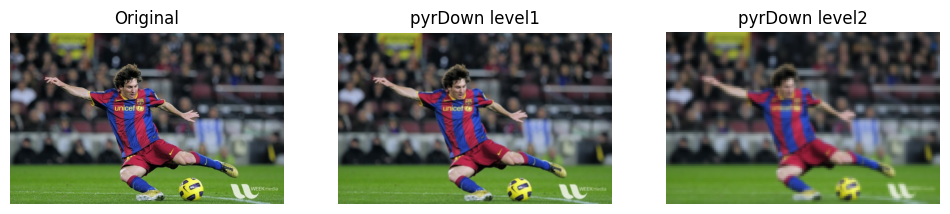

In [ ]:
img = cv.imread('messi5.jpg')
if img is None:
    raise FileNotFoundError("Image not found.")

level1 = cv.pyrDown(img)
level2 = cv.pyrDown(level1)
# 역으로 올리기
level1_up = cv.pyrUp(level1)
level2_up = cv.pyrUp(level2)

print("Original shape:", img.shape)
print("Level1 shape:", level1.shape)
print("Level2 shape:", level2.shape)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(cv.cvtColor(level1, cv.COLOR_BGR2RGB))
plt.title('pyrDown level1'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(cv.cvtColor(level2, cv.COLOR_BGR2RGB))
plt.title('pyrDown level2'); plt.axis('off')
plt.show()

# 4. Laplacian Pyramid
라플라시안 피라미드는 $G_i - pyrUp(G_{i+1})$(가우시안 피라미드 간 차이)로 만들 수 있습니다.
OpenCV에 직접적인 함수는 없고, 수식으로 구현해야 합니다.

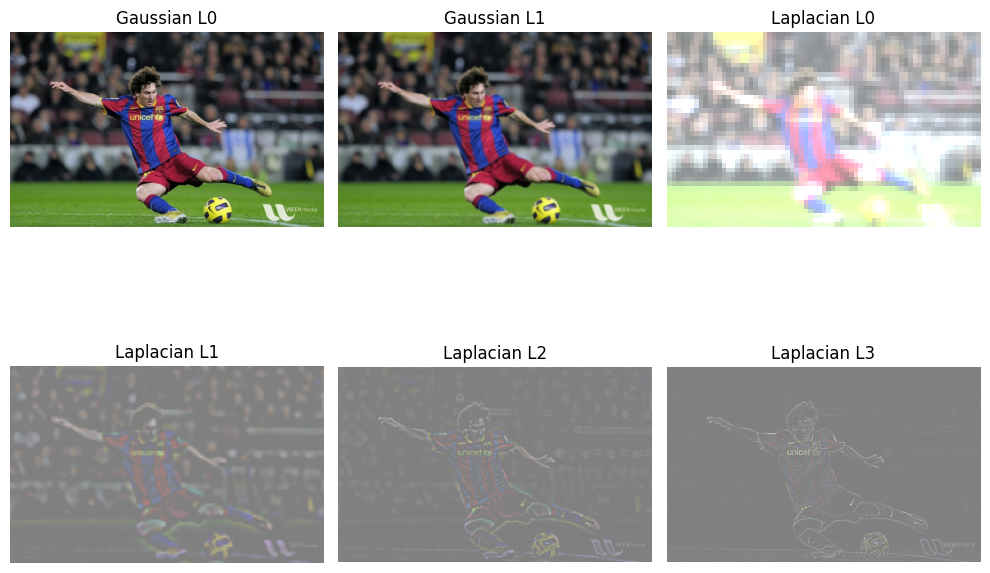

In [ ]:
def build_gaussian_pyramid(img, levels=3):
    # levels=3 means 0,1,2,
    g_pyr = [img]
    tmp = img
    for i in range(levels):
        tmp = cv.pyrDown(tmp)
        g_pyr.append(tmp)
    return g_pyr

def build_laplacian_pyramid(g_pyr):
    # g_pyr[-1] is the smallest Gaussian level
    l_pyr = [g_pyr[-1]]  # last level is same in Laplacian
    for i in range(len(g_pyr)-1, 0, -1):
        # expand g_pyr[i] and subtract from g_pyr[i-1]
        up = cv.pyrUp(g_pyr[i])
        # make sure shapes match
        up = up[:g_pyr[i-1].shape[0], :g_pyr[i-1].shape[1]]
        lap = cv.subtract(g_pyr[i-1], up)
        l_pyr.append(lap)
    return l_pyr

g_levels = 3
g_pyr = build_gaussian_pyramid(img, g_levels)
l_pyr = build_laplacian_pyramid(g_pyr)

# 시각화
plt.figure(figsize=(10,8))
for i, gp in enumerate(g_pyr):
    plt.subplot(2,g_levels, i+1)
    plt.imshow(cv.cvtColor(gp, cv.COLOR_BGR2RGB))
    plt.title(f'Gaussian L{i}')
    plt.axis('off')

for j, lp in enumerate(l_pyr):
    plt.subplot(2, g_levels, g_levels + j)
    # Laplacian can have negative, so shift to display
    # or just convert to absolute
    show = cv.convertScaleAbs(lp, alpha=1.0, beta=128)
    plt.imshow(cv.cvtColor(show, cv.COLOR_BGR2RGB))
    plt.title(f'Laplacian L{j}')  # Changed to reflect level j in l_pyr
    plt.axis('off')

plt.tight_layout()
plt.show()

# 5. Blending (Orange + Apple = Orapple)
여기서는 오렌지와 사과 이미지를 결합하는 예시를 합니다. (이미지 크기는 같아야 하거나, 맞춰줘야 함.)
순서:
1. 사과(A), 오렌지(B) 읽기
2. 각자 6레벨 Gaussian Pyramid 구성
3. Gaussian Pyramid → Laplacian Pyramid
4. 각 레벨에서 왼쪽은 A Laplacian, 오른쪽은 B Laplacian
5. 최종 합쳐서 **역피라미드**로 복원.
6. 직접 좌우를 붙인 결과와 비교.

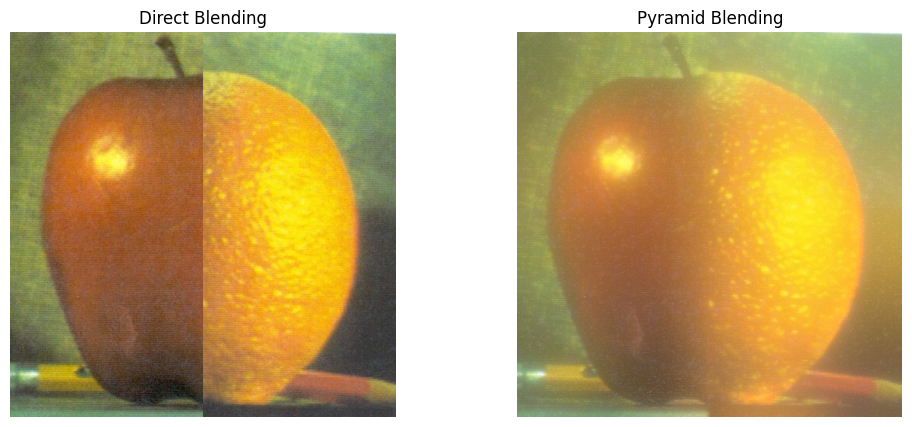

In [ ]:
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/data/apple.jpg -O apple.jpg
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/data/orange.jpg -O orange.jpg

A = cv.imread('apple.jpg')
B = cv.imread('orange.jpg')

if A is None or B is None:
    print("apple.jpg / orange.jpg not found.")
else:
    # For blending, let's ensure same size
    # (Or resize one to match the other)
    rows = min(A.shape[0], B.shape[0])
    cols = min(A.shape[1], B.shape[1])
    A = A[:rows, :cols]
    B = B[:rows, :cols]

    # Direct half-split
    real = np.hstack((A[:, :cols//2], B[:, cols//2:]))

    # Build Gaussian pyramids
    G_A = [A]
    G_B = [B]
    levels = 6
    for i in range(levels):
        G_A.append(cv.pyrDown(G_A[-1]))
        G_B.append(cv.pyrDown(G_B[-1]))

    # Build Laplacian pyramids
    L_A = [G_A[-1]]
    L_B = [G_B[-1]]
    for i in range(levels-1, -1, -1):
        GA_up = cv.pyrUp(G_A[i+1])
        GA_up = GA_up[:G_A[i].shape[0], :G_A[i].shape[1]]
        LA = cv.subtract(G_A[i], GA_up)
        L_A.append(LA)

        GB_up = cv.pyrUp(G_B[i+1])
        GB_up = GB_up[:G_B[i].shape[0], :G_B[i].shape[1]]
        LB = cv.subtract(G_B[i], GB_up)
        L_B.append(LB)

    # Blend each level's laplacian
    LS = []
    for la, lb in zip(L_A, L_B):
        la_cols = la.shape[1]
        ls = np.hstack((la[:, :la_cols//2], lb[:, la_cols//2:]))
        LS.append(ls)

    # Reconstruct
    blend = LS[0]
    for i in range(1, len(LS)):
        blend = cv.pyrUp(blend)
        blend = blend[:LS[i].shape[0], :LS[i].shape[1]]
        blend = cv.add(blend, LS[i])

    # Save or show results
    cv.imwrite('Pyramid_blending.jpg', blend)
    cv.imwrite('Direct_blending.jpg', real)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(real, cv.COLOR_BGR2RGB))
    plt.title('Direct Blending')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv.cvtColor(blend, cv.COLOR_BGR2RGB))
    plt.title('Pyramid Blending')
    plt.axis('off')
    plt.show()

# 6. 과제
1. **피라미드 레벨**(`levels`)을 다르게 설정(3~6)하여 결과 비교.
2. **왼쪽/오른쪽** 대신, **위/아래**로 split해서 블렌딩 시도.
3. **이미지를 다르게** (동일 크기) 해서 blending 실습.
4. **Laplacian Pyramids**를 시각화해보고, contrast를 조정해 어느 부분이 남는지 확인.
5. **동영상**(frame by frame) blending or multi-band blending.


# 7. Q&A
- **Q**: `cv.pyrDown` 한 번 호출 시, 크기가 얼마나 줄어드나요?
  - **A**: 가로/세로 각각 절반. 면적은 1/4.
- **Q**: `cv.pyrUp`으로 되돌렸을 때, 원본과 동일한가요?
  - **A**: 완전히 동일하지 않습니다(정보 손실).
- **Q**: 라플라시안 피라미드가 왜 edge처럼 보이나요?
  - **A**: 상위 레벨 Gaussian을 expand해 빼기 때문, 대부분의 일정 영역(평탄부)은 0근처가 되고, 변화(에지) 부분만 남습니다.
- **Q**: Blending 시, 왜 여러 레벨에서 반씩 나누어 합치나요?
  - **A**: 라플라시안 피라미드는 각 레벨별 해상도에서 경계를 자연스럽게 보정하기 위해.

이상으로 **이미지 피라미드**(Gaussian, Laplacian)와 **Blending**(오렌지+사과) 과정을 Colab에서 학습했습니다.
추가 과제를 통해 다양한 이미지를 시도해 보세요!